In [1]:
## This version excludes CONTINUOUS Variables and the RFD variables AND _wHICH VARIABLES 3/27/2024 and con_max_consultorder_time/day and drg name
## 4/4/2024 Added QUINTILE variables
## 4/8/2024 Added QUINTILE varables by service
## 4/9/2024 Added more consult and imaging variables (e.g. ad,it order to consult order, admit order to imaging read)
## 4/11/2024 Added QUINTILE variables by service for the additional variables
## 4/13/2024 Added con_unique_services_which and con_unique_services_which2 variables
## 4/16/2024 Updated criteria for heart failure and GI

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.imputation import AddMissingIndicator
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from feature_engine.discretisation import DecisionTreeDiscretiser
from sklearn.model_selection import GroupShuffleSplit

from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
from sklearn.impute import SimpleImputer

#pip install xgboost==0.90
import xgboost as xgb
import plotly.express as px
import shap

#https://github.com/liannewriting/YouTube-videos-public/blob/main/xgboost-python-tutorial-example/xgboost_python.ipynb
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
#hyperparameter values
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_all = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/clean/master_los.csv', index_col=[0])

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df_all["con_unique_services_which2"].value_counts()

con_unique_services_which2
Multiple                                6041
Cardiology                               516
Pharmacy                                 482
Gastroenterology                         472
Neurology                                389
Nephrology                               360
Diabetes                                 209
Palliative                               172
Pulmonology                              150
Addiction Medicine                       144
Surgery                                  129
Psychiatry                               128
Geriatrics                               123
Hospitalist Service                      101
Infectious Disease                        76
Urology                                   75
Other                                     72
Oncology                                  68
Hematology                                59
Orthopedics                               57
ICU/SDU                                   50
Podiatry                    

In [6]:
df_all["viz_disp_collapsed"].value_counts()

viz_disp_collapsed
Other    8346
Home     4859
Name: count, dtype: int64

In [7]:
df_all["thro_boarding_yn"].value_counts()

thro_boarding_yn
1.0    6895
0.0    5585
Name: count, dtype: int64

In [8]:
df_all["viz_drg"].value_counts()

viz_drg
Septicemia or severe sepsis w/o mv >96 hours w mcc                                           2080
heart failure & shock w mcc                                                                  1390
Respiratory infections & inflammations w mcc                                                 1066
Esophagitis, gastroent & misc digest disorders w/o mcc                                        682
Simple pneumonia & pleurisy w mcc                                                             640
Cellulitis w/o mcc                                                                            456
Renal failure w mcc                                                                           438
Septicemia or severe sepsis w/o mv >96 hours w/o mcc                                          437
Pulmonary edema & respiratory failure                                                         430
Infectious & parasitic diseases w o.r. procedure w mcc                                        353
Intracranial

In [9]:
#Filter for home patients
#df_filt = df_all.copy()
drg_gi = ["Esophagitis, gastroent & misc digest disorders w/o mcc","Esophagitis, gastroent & misc digest disorders w mcc","G.i. hemorrhage w cc","G.i. hemorrhage w mcc"]
df_filt = df_all[(df_all["con_unique_services_which2"]=="Gastroenterology") | df_all["viz_drg"].isin(drg_gi)]
#df_filt = df_all[df_all["viz_service_collapsed"]=="Neurology"]
#df_filt = df_all[df_all["viz_drg"]=="heart failure & shock w mcc"].copy()
#df_filt = df_all[df_all["viz_disp_collapsed"] == "Home"].copy()
#df_filt = df_all[df_all["thro_boarding_yn"] == 1].copy()

In [10]:
df_all["viz_drg"].isin(drg_gi).sum()

1495

In [11]:
df_filt.shape

(1645, 922)

In [12]:
# aitc_features.xlsx includes all the feature names and corresponding types
features_los = pd.read_excel('/gpfs/milgram/project/rtaylor/imc33/data/clean/features_los.xlsx')

# Features that are divided into 5 types to conduct data preprocessing
# 1. drop: features that need to be dropped
drop_list = features_los[features_los['type'] == 'drop']['col_name'].tolist()

# 2. category: features that are already categorical and need to be OneHotEncoding (add missing value indicator, impute missing by adding 'missing' category)
category_list = features_los[features_los['type'] == 'category']['col_name'].tolist()

# 3. binary: features that are binary and need to be converted to categorical (add missing value indicator / prefer: fill missing with 0)
binary_list = features_los[features_los['type'] == 'binary']['col_name'].tolist()

# 4. continuous: features that are continous/numerical variables, need outlier handling and normalization (add missing value indicator, fill missing with median)
continuous_list = features_los[features_los['type'] == 'continuous']['col_name'].tolist()

# 5. discrete: features that are discrete/numerical variables, need to be discretized (fill missing with 0)
discrete_list = features_los[features_los['type'] == 'discrete']['col_name'].tolist()

In [13]:
# Identify variables with infinite values
#variables_with_inf = df_filt.columns[df_filt.isin([np.inf, -np.inf]).any()]

# Handle infinite values (e.g., replace with NaN)
#df_filt[variables_with_inf] = df_filt[variables_with_inf].replace([np.inf, -np.inf], np.nan)

In [14]:
# Split into X, y
X = df_filt.drop(['viz_outcome_prolonged_los_yn'], axis=1)
y = df_filt['viz_outcome_prolonged_los_yn']

In [15]:
# Convert variables to categorical
X[binary_list] = X[binary_list].astype('category')
X[category_list] = X[category_list].astype('category')

In [16]:
# Drop features that have >= 99% missing values And features in drop list
missing_pct = X.isnull().mean() * 100
cols_to_drop = missing_pct[missing_pct >= 99].index.tolist()
#final_drop_list = list(set(drop_list + cols_to_drop))
#X_1b = X_1b.drop(columns=final_drop_list)
#X_1b = X_1b.reset_index(drop=True)
#y_1b = y_1b.reset_index(drop=True)

In [17]:
pd.set_option('display.max_rows', 400)

In [18]:
missing_pct.reset_index().sort_values(0, ascending=False).head()

index      0
683  con_avg_admit_order_to_consult_order_picc_quin...  100.0
509  con_max_admit_order_to_consult_order_addiction...  100.0
511   con_max_admit_order_to_consult_order_icu_sdu_hrs  100.0
512    con_max_admit_order_to_consult_order_trauma_hrs  100.0
675        con_avg_admit_order_to_consult_order_sw_hrs  100.0

In [19]:
continuous_list.remove("viz_age")

In [20]:
# We do NOT want to drop these
#cols_to_drop
#only these
drop_list

['rfd_first_nmr_start_day',
 'rfd_first_nmr_start_time',
 'rfd_first_mrnb_start_day',
 'rfd_first_mrnb_start_time',
 'rfd_first_mrwb_start_day',
 'rfd_first_mrwb_start_time',
 'rfd_last_nmr_effective_end_day',
 'rfd_last_nmr_effective_end_time',
 'rfd_last_mrnb_effective_end_day',
 'rfd_last_mrnb_effective_end_time',
 'rfd_last_mrwb_effective_end_day',
 'rfd_last_mrwb_effective_end_time',
 'con_max_consult_order_to_sign_which',
 'con_max_consult_order_time',
 'con_max_consult_order_day',
 'con_max_date_note_signed_time1',
 'con_max_date_note_signed_day1',
 'con_max_consult_note_to_sign_which',
 'admissiondate',
 'ed_arrival_time',
 'ed_arrival_hour',
 'ed_arrival_date',
 'dischargedate',
 'con_max_consult_order_to_sign_colon_and_rectal_hrs',
 'con_max_consult_order_to_sign_picc_hrs',
 'con_max_consult_order_to_sign_pharmacy_hrs',
 'con_max_consult_order_to_sign_sw_hrs',
 'con_max_admit_order_to_consult_order_any_hrs',
 'con_avg_admit_order_to_consult_order_any_hrs',
 'img_max_admit_ord

In [21]:
X

admissiondate dischargedate pat_mrn_id  \
pat_enc_csn_id                                          
307763395         2022-12-18    2023-01-02   MR537961   
308411999         2022-12-25    2023-01-05   MR757905   
308433336         2022-12-26    2023-01-01  MR1469132   
308415657         2022-12-26    2023-01-03   MR314408   
308541050         2022-12-27    2023-01-01  MR7145985   
...                      ...           ...        ...   
343766387         2023-12-27    2023-12-29  MR1060966   
343858876         2023-12-27    2023-12-29   MR303777   
343884916         2023-12-28    2023-12-30  MR1248072   
343886798         2023-12-28    2023-12-30   MR952573   
343974170         2023-12-29    2023-12-31  MR6725773   

                                  viz_primary_payer_name viz_disp_collapsed  \
pat_enc_csn_id                                                                
307763395                          Medicare/Managed Care              Other   
308411999                          Medicare/Managed Care              Other   
308433336                 Medicare Traditional/Indemnity               Home   
308415657                 Medicare Traditional/Indemnity              Other   
308541050                          Medicaid/Managed Care               Home   
...                                                  ...                ...   
343766387                          Medicare/Managed Care              Other   
343858876                 Medicaid Traditional/Indemnity               Home   
343884916                 Medicaid Traditional/Indemnity               Home   
343886798                          Medicare/Managed Care               Home   
343974170       Commercial/Private Traditional/Indemnity               Home   

                viz_age        viz_ethnicity viz_race viz_race_collapsed  \
pat_enc_csn_id                                                             
307763395            87  Non Hispanic Origin    White              White   
308411999            66  Non Hispanic Origin    Black          Non-White   
308433336            90  Non Hispanic Origin    White              White   
308415657            82  Non Hispanic Origin    Black          Non-White   
308541050            39  Non Hispanic Origin    White              White   
...                 ...                  ...      ...                ...   
343766387            96  Non Hispanic Origin    White              White   
343858876            50      Hispanic Origin    White              White   
343884916            36  Non Hispanic Origin    White              White   
343886798            64  Non Hispanic Origin    Black          Non-White   
343974170            46  Non Hispanic Origin    White              White   

               viz_language     viz_insurance viz_service_collapsed  \
pat_enc_csn_id                                                        
307763395           English  Managed Medicare              Medicine   
308411999           English  Managed Medicare              Medicine   
308433336           English          Medicare              Medicine   
308415657           English          Medicare              Medicine   
308541050           English          Medicaid              Medicine   
...                     ...               ...                   ...   
343766387           English  Managed Medicare              Medicine   
343858876             Other          Medicaid              Medicine   
343884916           English          Medicaid              Medicine   
343886798           English  Managed Medicare              Medicine   
343974170           English        Commercial              Medicine   

                     viz_ynhhs_sg2_service viz_observed_mortality_yn  \
pat_enc_csn_id                                                         
307763395       Digestive Health - Medical                         0   
308411999       Digestive Health - Medical                         0   
308433336       Digestive Health - Medical  

In [22]:
X = X.drop(columns=drop_list+continuous_list)
X = X.reset_index()
y = y.reset_index()

In [23]:
# Split the data by group shuffle split on 'PAT_MRN_ID' into train set and validation set
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

train_ix, val_ix = next(gss.split(X, y, groups=X['pat_mrn_id']))

X_train = X.loc[train_ix]
y_train = y.loc[train_ix]

X_val = X.loc[val_ix]
y_val = y.loc[val_ix]

# Drop 'PAT_MRN_ID' and set 'PAT_ENC_CSN_ID' as index
X_train = X_train.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')
X_val = X_val.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')

### Feature Processing

In [24]:

# Update feature preprocessing pipeline
feature_preprocess_pipeline = Pipeline(steps=[

    # Missing value indicator for categoricals and continuous variables
    #('missing_indicator', AddMissingIndicator(variables=category_list + continuous_list)),

    # Missing value imputation
    # Impute missing values with 0 for discrete variables
    ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=discrete_list)),

  
    # Impute missing values with adding 'missing' category for categorical variables 
   ('categorical_imputer', CategoricalImputer(variables=category_list)),

    # Impute missing values with 0 for binary variables 
    ('binary_imputer', CategoricalImputer(fill_value='0', variables=binary_list)),

    
    # Rare encoding for categorical variables
    ('rare_label_encoder', RareLabelEncoder(tol=0.01, n_categories=5, max_n_categories=10, variables=category_list)),

    # OneHotEncoding for categoricals
    ('one_hot_category', OneHotEncoder(variables=category_list)),

    # Outlier handling & normalization for continous variables
   #('outlier_handling', Winsorizer(capping_method='gaussian', tail='right', fold=3, variables=continuous_list)),
    #todo: 

  # ('normalize', SklearnTransformerWrapper(MinMaxScaler(feature_range=(0, 1)), variables=continuous_list)),

    # discretize for discrete variables
   #('discretize', DecisionTreeDiscretiser(cv=3, scoring='roc_auc', regression=False, random_state=42, variables=discrete_list))
    #todo:
    
])  # Apply the pipeline

In [25]:
# Apply the pipeline
X_train_preprocessed = feature_preprocess_pipeline.fit_transform(X_train, y_train)
X_val_preprocessed = feature_preprocess_pipeline.transform(X_val)

In [26]:
X_train_preprocessed.shape

(1319, 1624)

In [27]:
X_train_preprocessed.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_preprocessed_byconsult_patients_cat_only.csv')
X_val_preprocessed.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_preprocessed_byconsult_patients_cat_only.csv')

### Feature Selection

In [28]:
# 1st Feature Selection pipeline
feature_selection_pipeline = Pipeline(steps=[

        ('drop_constant', DropConstantFeatures(tol=0.99)),

        ('drop_duplicates', DropDuplicateFeatures()),

        ('correlated_features', SmartCorrelatedSelection(
        method='pearson',
        threshold=0.9,
        selection_method='model_performance',
        estimator=xgb.XGBClassifier(random_state=0)
        ))
])

In [29]:
miss_df = X_train_preprocessed.isna().sum().reset_index()
miss_df[miss_df[0]>0]
miss_df[miss_df[0]>0].to_csv("miss_df.csv", index=False)

In [30]:
# Apply the pipeline
X_train_selected = feature_selection_pipeline.fit_transform(X_train_preprocessed, y_train['viz_outcome_prolonged_los_yn'])
X_val_selected = feature_selection_pipeline.transform(X_val_preprocessed)

In [31]:
X_train_selected.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_initial_selected_byconsult_patients_cat_only.csv')
X_val_selected.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_initial_selected_byconsult_patients_cat_only.csv')

In [32]:
X_train_preprocessed.shape

(1319, 1624)

In [33]:
X_train_selected.shape

(1319, 460)

In [34]:
# Read files
#X_train_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_initial_selected_byconsult_patients_cat_only.csv')
#X_val_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_initial_selected_byconsult_patients_cat_only.csv')

In [35]:
#train_selected = X_train_selected.merge(y_train, on='pat_enc_csn_id', how='left')
#val_selected = X_val_selected.merge(y_val, on='pat_enc_csn_id', how='left')

In [36]:
#train_selected = train_selected.set_index('pat_enc_csn_id')
#val_selected = val_selected.set_index('pat_enc_csn_id')

In [37]:
# Top 20 features - training set
#get_best_features(num_feats = 20, df = train_selected, df_name = 'train', target = 'viz_outcome_prolonged_los_yn')

In [38]:
y_train['viz_outcome_prolonged_los_yn'].sum()/y_train.shape[0]

0.4874905231235785

In [39]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8, verbosity=1))
]

tuning_pipeline = Pipeline(steps=estimators)

In [40]:
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

model_xgb = BayesSearchCV(tuning_pipeline, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 

In [41]:
#y_train = y_train.set_index('pat_enc_csn_id')

In [42]:
y_train = y_train.set_index('pat_enc_csn_id')

In [43]:
#X_train_selected = X_train_selected.set_index('pat_enc_csn_id')

In [44]:
model_xgb.fit(X_train_selected,  y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [45]:
model_xgb.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['thro_boarding_yn',
                                     'con_max_consult_order_to_sign_is_signer_ym_provider_yn',
                                     'con_max_consult_order_to_sign_is_signer_nemg_provider_yn',
                                     'con_max_consult_order_to_sign_is_signer_community_provider_yn',
                                     'icu_any_icu_yn'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.02796171154881776, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=2,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=8, ...))])

In [46]:
model_xgb.best_score_

0.7455232961697081

In [47]:
y_val = y_val.set_index('pat_enc_csn_id')

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Confusion Matrix

-- Of 5831 people who did not have a prolonged LOS, 5831 (86%) were correctly classified.
-- Of 4724 people who did have prolonged LOS, 3918 (83%) were correctly classified

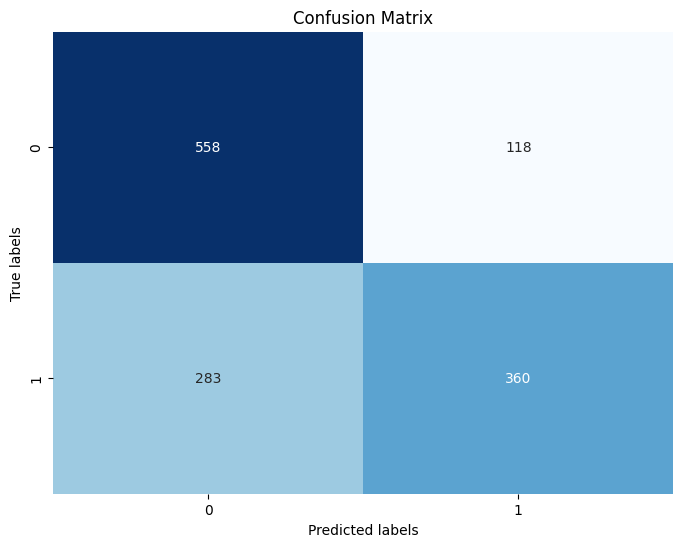

In [49]:
# Generate confusion matrix
cm = confusion_matrix(y_train, model_xgb.predict(X_train_selected))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [50]:
from sklearn import metrics

def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

In [51]:
test_preds = model_xgb.predict(X_val_selected)
target_test = y_val['viz_outcome_prolonged_los_yn']

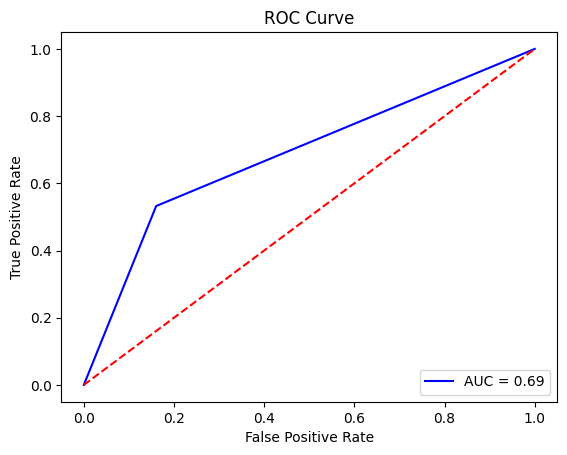

In [52]:
buildROC(target_test, test_preds)

In [53]:
def buildPR(target_test,test_preds):
    precision, recall, _ = metrics.precision_recall_curve(target_test, test_preds)
    pr_auc = metrics.auc(recall, precision)
    plt.title('PR Curve')
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f})')
    plt.legend(loc = 'lower right')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

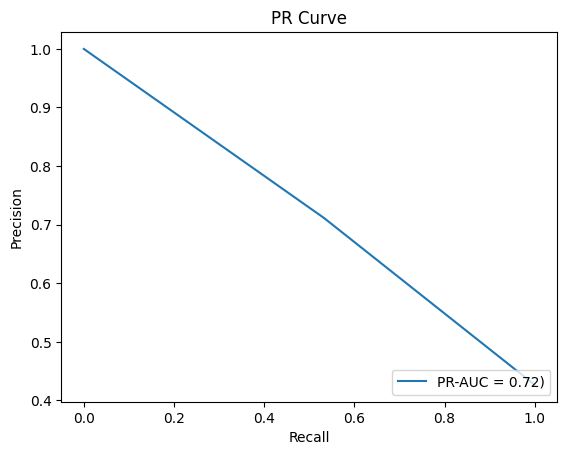

In [54]:
buildPR(target_test, test_preds)

In [55]:
def buildCC(target_test,test_preds):
      prob_true, prob_pred = calibration_curve(target_test, test_preds, n_bins=10)
      plt.plot(prob_pred, prob_true)
      plt.xlabel('Mean Predicted Probability')
      plt.ylabel('Fraction of Positives')

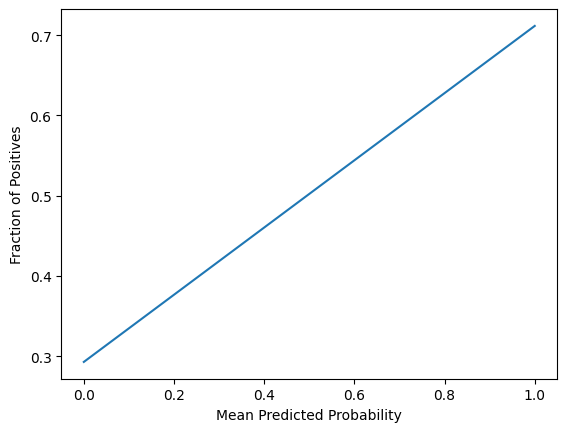

In [56]:
buildCC(target_test, test_preds)

In [57]:
#model_xgb.predict_proba(X_val)

In [58]:
model_xgb.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['thro_boarding_yn',
                      'con_max_consult_order_to_sign_is_signer_ym_provider_yn',
                      'con_max_consult_order_to_sign_is_signer_nemg_provider_yn',
                      'con_max_consult_order_to_sign_is_signer_community_provider_yn',
                      'icu_any_icu_yn'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.8255063664935096,
                colsample_bynode=0.9566459979367115,
                colsample_bytree=0.7745652753956729, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=9.034580483401264,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.02796171154881776,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_dep

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

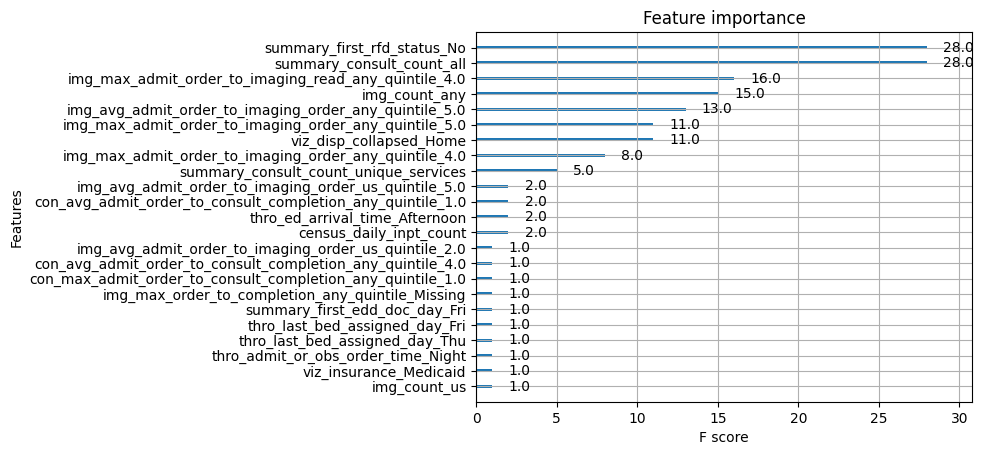

In [59]:
#https://www.youtube.com/watch?v=aLOQD66Sj0g&ab_channel=LianneandJustin
from xgboost import plot_importance

xgboost_step = model_xgb.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model, max_num_features=30)

In [60]:
xgboost_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8255063664935096,
              colsample_bynode=0.9566459979367115,
              colsample_bytree=0.7745652753956729, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=9.034580483401264,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02796171154881776,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=8, ...)

In [61]:
X_train_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_initial_selected_byconsult_patients_cat_only.csv', index_col=[0])

In [62]:
X_val_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_initial_selected_byconsult_patients_cat_only.csv', index_col=[0])

In [63]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train_selected, 
            y_train['viz_outcome_prolonged_los_yn'], 
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_val_selected, y_val['viz_outcome_prolonged_los_yn'])])

[0]	validation_0-aucpr:0.70049
[1]	validation_0-aucpr:0.72404
[2]	validation_0-aucpr:0.73427
[3]	validation_0-aucpr:0.74145
[4]	validation_0-aucpr:0.75486
[5]	validation_0-aucpr:0.74772
[6]	validation_0-aucpr:0.73753
[7]	validation_0-aucpr:0.75880
[8]	validation_0-aucpr:0.75366
[9]	validation_0-aucpr:0.76763
[10]	validation_0-aucpr:0.76243
[11]	validation_0-aucpr:0.76538
[12]	validation_0-aucpr:0.76222
[13]	validation_0-aucpr:0.77402
[14]	validation_0-aucpr:0.77682
[15]	validation_0-aucpr:0.77957
[16]	validation_0-aucpr:0.77725
[17]	validation_0-aucpr:0.77422
[18]	validation_0-aucpr:0.77969
[19]	validation_0-aucpr:0.78167
[20]	validation_0-aucpr:0.78427
[21]	validation_0-aucpr:0.78470
[22]	validation_0-aucpr:0.78864
[23]	validation_0-aucpr:0.78725
[24]	validation_0-aucpr:0.78183
[25]	validation_0-aucpr:0.78195
[26]	validation_0-aucpr:0.78851
[27]	validation_0-aucpr:0.78931
[28]	validation_0-aucpr:0.78754
[29]	validation_0-aucpr:0.79007
[30]	validation_0-aucpr:0.78872
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [64]:
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_val_selected)

In [65]:
#1 shap value for each feature
np.shape(shap_values.values)

(326, 460)

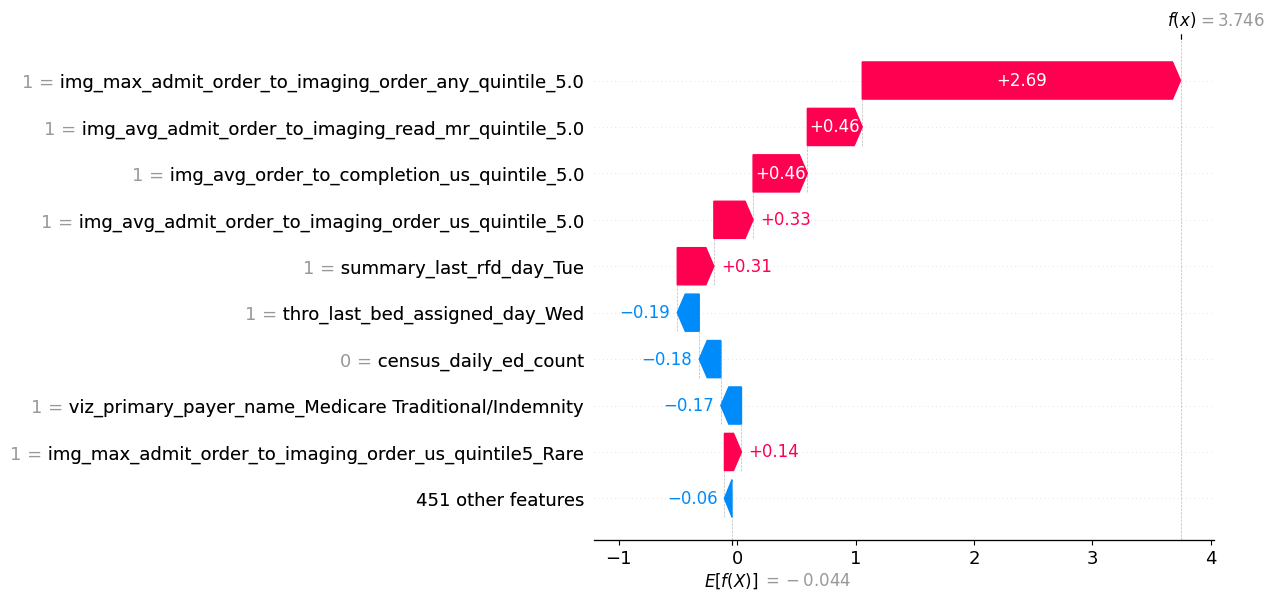

In [66]:
#This is for a single prediction
shap.plots.waterfall(shap_values[0])

In [67]:
shap.initjs(),
shap.plots.force(shap_values[0])

In [68]:
shap.plots.force(shap_values[0:100])

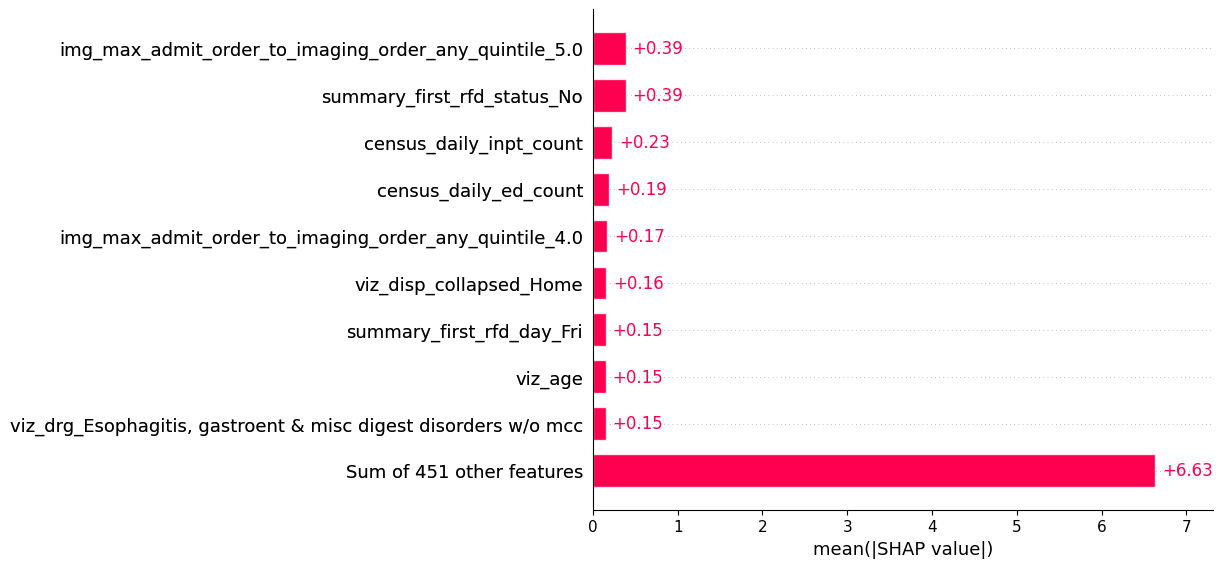

In [69]:
shap.plots.bar(shap_values)

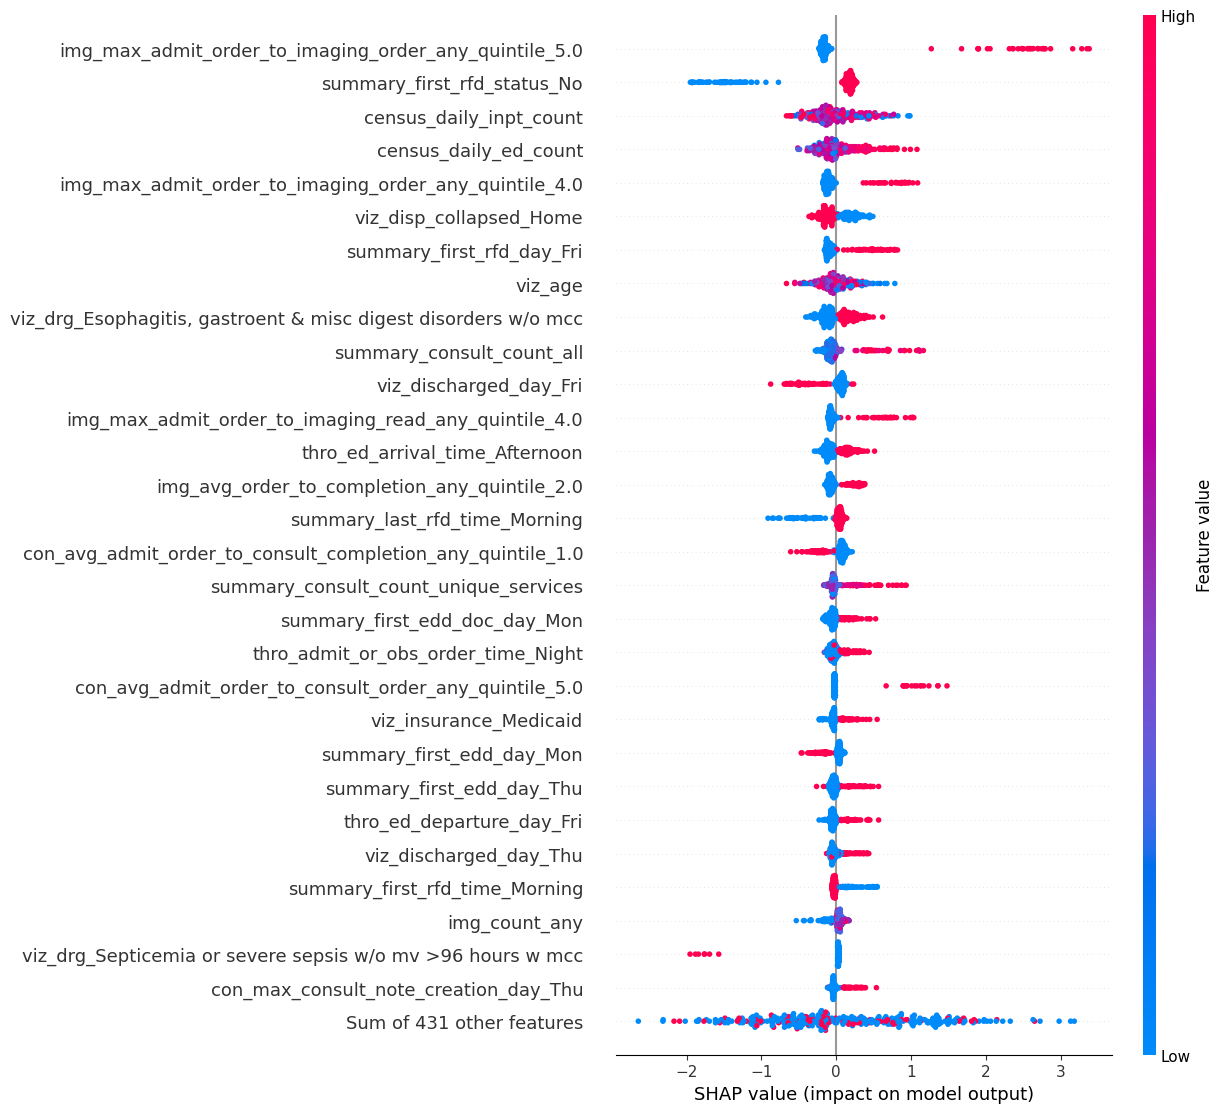

In [70]:
shap.plots.beeswarm(shap_values, max_display=30)